<a href="https://www.kaggle.com/code/maktas/adversarial-attack-tutorial?scriptVersionId=111814551" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Adversarial Attack Tutorial

This repository uses pretrained model and generates the adversarial examples that fool the network. The pretrained models are loaded from Google "Transfer learning with TensorFlow Hub" at https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub

# Setup

In [1]:
import numpy as np
import time
import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import datetime
%load_ext tensorboard
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms

# Network Parameters

In [2]:
IMAGE_SHAPE = (224, 224)

# Load input image

In [3]:
im = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
#im = tf.keras.utils.get_file('image.jpg','https://media.cnn.com/api/v1/images/stellar/prod/220818142713-dogs-tears-emotions-wellness-stock.jpg?c=16x9&q=h_720,w_1280,c_fill')
input_org_image = Image.open(im).resize(IMAGE_SHAPE)
testX = np.array(input_org_image)/255.0
model_input_org = testX[np.newaxis, ...]

73728/61306 [====================================] - 0s 0us/step


Show input image

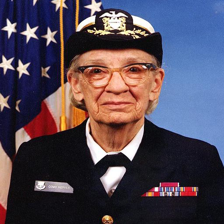

In [4]:
display(input_org_image)

In [5]:
# convert to pytorch format
torch_testX = torch.from_numpy( np.transpose(model_input_org, (0, 3, 1, 2)) ).float().cuda()

# Load pretrained model

In [6]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
resnet_v2_101 = "https://tfhub.dev/google/imagenet/resnet_v2_101/classification/5"
resnet_v2_152 = "https://tfhub.dev/google/imagenet/resnet_v2_152/classification/5"

classifier_model = mobilenet_v2

In [7]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

2022-11-23 04:42:35.291623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 04:42:35.292680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 04:42:35.293336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 04:42:35.294097: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Get the predicted label for original input

In [8]:
result = classifier.predict(model_input_org)
predicted_class = tf.math.argmax(result[0], axis=-1)

2022-11-23 04:42:37.654953: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-23 04:42:39.287338: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


## GENERATE ADVERSARIAL EXAMPLE

# Adversarial attack parameters

In [9]:
epsilon = 8/255.0

# Autoattack
https://github.com/fra31/auto-attack

In [10]:
# Install AutoAttack
! pip install git+https://github.com/fra31/auto-attack

  Cloning https://github.com/fra31/auto-attack to /tmp/pip-req-build-mnfod4k6
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack /tmp/pip-req-build-mnfod4k6
  Resolved https://github.com/fra31/auto-attack to commit b7f560b229145e6e90613cd3ce98cad6a94bd623
  Preparing metadata (setup.py) ... done
  Created wheel for autoattack: filename=autoattack-0.1-py3-none-any.whl size=34633 sha256=91e632a41950abe12b3e5efb6199348cb5e45c1e3ba92cd8d9fc84be1078f4ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-1jv4dyws/wheels/a2/71/8b/ec4bb51ceac509961546bf5430b7cf433f93bd375ffa75ea45
Successfully built autoattack


In [11]:
from autoattack import utils_tf2
from autoattack import AutoAttack

Convert Tensorflow model to Pytorch model

In [12]:
model_adapted = utils_tf2.ModelAdapter(classifier)
adversary = AutoAttack(model_adapted, norm='Linf', eps=epsilon, version='standard', is_tf_model=True)

[WARNING] Can not find Conv2D layer
[INFO] Because detecting input_shape[3] == 3, set data_format = 'channels_last'
setting parameters for standard version


In [13]:
# Convert original input class id to Pytorch format
torch_testY = torch.from_numpy(np.array([predicted_class.numpy()])).cuda()

Apply Autoattack for generating Adversarial example 

In [14]:
batch_size = 1
# run attack
adversary = AutoAttack(model_adapted, norm='Linf', eps=epsilon, version='standard', is_tf_model=True)
x_adv, y_adv = adversary.run_standard_evaluation(torch_testX, torch_testY, bs=batch_size, return_labels=True)
model_input_adv = np.moveaxis(x_adv.cpu().numpy(), 1, 3)

setting parameters for standard version
using standard version including apgd-ce, apgd-t, fab-t, square
initial accuracy: 100.00%
apgd-ce - 1/1 - 1 out of 1 successfully perturbed
robust accuracy after APGD-CE: 0.00% (total time 5.0 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 0.00%


# Illustrate results

In [15]:
def Show_Results(model_input,title_str):
    result = classifier.predict(model_input)
    predicted_class = tf.math.argmax(result[0], axis=-1)
    score = tf.reduce_max(tf.nn.softmax(result[0]), axis=-1).numpy()
    labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
    imagenet_labels = np.array(open(labels_path).read().splitlines())
    plt.figure()
    plt.imshow(model_input[0,:,:,:])
    plt.axis('off')
    predicted_class_name = imagenet_labels[predicted_class]
    score_str = "%.2f"%(score*100.0)
    _ = plt.title(title_str + predicted_class_name.title() + " (%" + score_str + ")")
    
    return tf.nn.softmax(result[0]).numpy()

24576/10484 [======================================================================] - 0s 0us/step


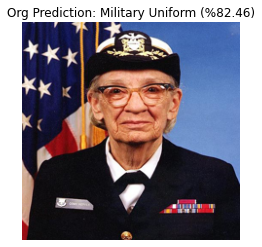

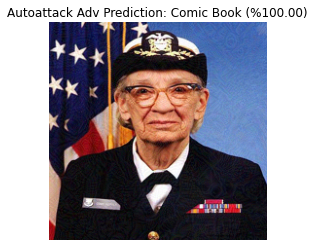

In [16]:
_ = Show_Results(model_input_org,"Org Prediction: ")
_ = Show_Results(model_input_adv,"Autoattack Adv Prediction: ")

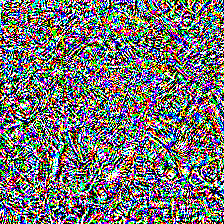

In [17]:
# Illustrate the adversarial noise
new_image_diff = Image.fromarray((model_input_adv[0,:,:,:]*255.0 - model_input_org[0,:,:,:]*255.0).astype('uint8'))
display(new_image_diff)